In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "/media/george-vengrovski/Extreme SSD/YardenLLB3_PreExtracted_WithPitch_Shift/saved_weights/model_step_0.pth"
config_path = "/media/george-vengrovski/Extreme SSD/YardenLLB3_PreExtracted_WithPitch_Shift/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image, deterimine_number_unique_classes

train_dir = "/media/george-vengrovski/Extreme SSD/yarden_data/llb3_data_matrices_train"
test_dir = "/media/george-vengrovski/Extreme SSD/yarden_data/llb3_data_matrices_test"

num_classes = deterimine_number_unique_classes(train_dir)

train_dataset = SongDataSet_Image(train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [3]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=2, layer_id="attention_output", TweetyBERT_readout_dims=196, classifier_type="linear_probe")
classifier_model = classifier_model.to(device)

Step 50: Train Loss 0.1927 FER = 5.10%, Val Loss = 0.1636
Step 100: Train Loss 0.1209 FER = 4.55%, Val Loss = 0.1262
Step 150: Train Loss 0.1126 FER = 4.35%, Val Loss = 0.1198
Step 200: Train Loss 0.1272 FER = 4.20%, Val Loss = 0.1268
Step 250: Train Loss 0.1013 FER = 4.25%, Val Loss = 0.1284
Step 300: Train Loss 0.1118 FER = 4.16%, Val Loss = 0.1159
Step 350: Train Loss 0.1054 FER = 3.71%, Val Loss = 0.1088
Step 400: Train Loss 0.1254 FER = 4.50%, Val Loss = 0.1397
Step 450: Train Loss 0.1090 FER = 3.50%, Val Loss = 0.0940
Step 500: Train Loss 0.1072 FER = 3.61%, Val Loss = 0.0995
Step 550: Train Loss 0.1048 FER = 4.10%, Val Loss = 0.1089
Step 600: Train Loss 0.1104 FER = 3.13%, Val Loss = 0.0720
Step 650: Train Loss 0.1340 FER = 3.59%, Val Loss = 0.0974
Step 700: Train Loss 0.1121 FER = 3.73%, Val Loss = 0.1009
Step 750: Train Loss 0.1009 FER = 4.61%, Val Loss = 0.1348
Early stopping triggered


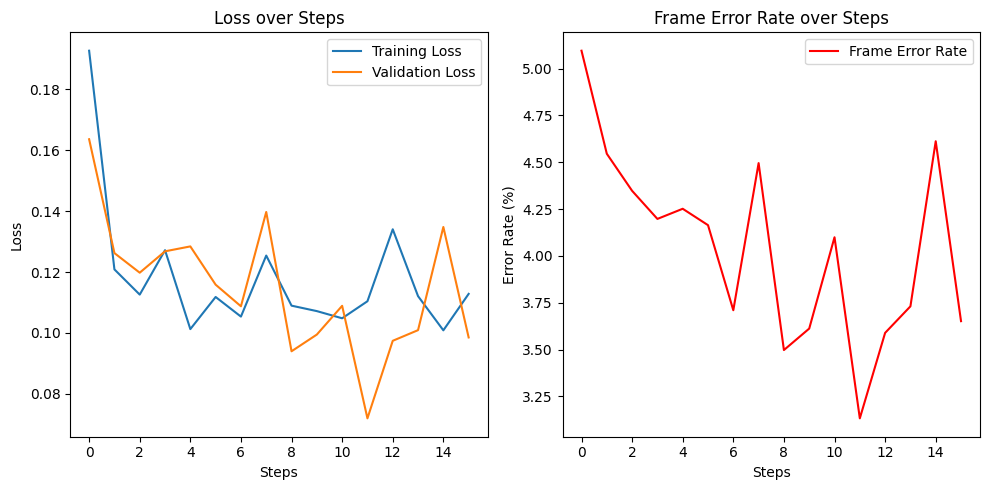

In [4]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=3e-4, plotting=True, batches_per_eval=50, desired_total_batches=1000, patience=4)
trainer.train()

## Analyze

In [5]:
from linear_probe import ModelEvaluator

# Initialize the ModelEvaluator with the filter_unseen_classes feature
evaluator = ModelEvaluator(model=classifier_model, 
                           test_loader=test_loader, 
                           num_classes=num_classes,  # Assuming there are 21 possible classes
                           device='cuda:0',  # Use CUDA if available
                           filter_unseen_classes=True,  # Enable filtering based on training set classes
                           train_dir=train_dir)  # Path to the training dataset directory

# Perform model validation with multiple passes
class_frame_error_rates, total_frame_error_rate = evaluator.evalulate_model(num_passes=1, max_batches=1250)

# Save the results to a specified directory, for example 'evaluation_results'
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results/')
